In [1]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import os
import pandas as pd
from scipy.ndimage import gaussian_filter1d as smooth
from scipy.io import loadmat

from aux import loadmat_h5, get_seg, get_outliers, mv_avg, align_t, zscore
from disp import set_plot, plot_b

cc = np.concatenate

T_MAX = 420
T_NRL = np.arange(T_MAX)
NROI = 20

T_SINE = np.array([40, 70, 100])
T_PULSE = np.array([130, 160, 190])
T_NAT = np.array([220, 300, 380, 460])

FLY_IDX = 0

FLIES = ['221014_a1']
EXPTS = [
    [f'{FLIES[0]}_{ctr}' for ctr in range(2,3)],
]

BHV_IDX_FRAME = 1
BHV_IDX_TIME = 21
BHV_IDX_SPEED = 18
DT_BHV = 1

# FNAME_STIM = 'data/original/lin_imaging/nat_song_imaging/10min_blocksplus_stim_1_forplotting.mat'
# SAVE_DIR = f'data/view/lin_20220830'

In [2]:
sng_df = pd.read_csv('data/stimuli_20220812/full_sine_quiet_pulse_quiet_nat_quiet.csv')

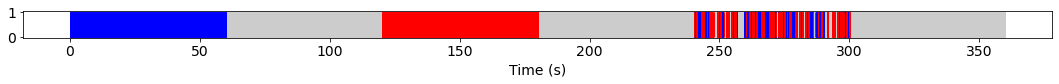

In [3]:
FPS_SNG = 30.03
DT_SNG = 1/FPS_SNG

sng_loaded = []

for dur, mode in zip(sng_df['DURATION'], sng_df['MODE']):
    nt = int(round(dur/DT_SNG))
    if mode == 'Q':
        sng_loaded.append(np.repeat(0, nt))
    elif mode == 'S':
        sng_loaded.append(np.repeat(1, nt))
    elif mode == 'P':
        sng_loaded.append(np.repeat(2, nt))
        
sng_loaded = cc(sng_loaded)
t_sng_loaded = DT_SNG*np.arange(len(sng_loaded))

fig, ax = plt.subplots(1, 1, figsize=(15, 1.25), tight_layout=True)
plot_b(
    ax, t_sng_loaded, sng_loaded, c=[(.8, .8, .8), 'b', 'r'],
    extent=[0, DT_SNG*len(sng_loaded), 0, 1])

set_plot(ax, x_label='Time (s)', font_size=14)

In [4]:
# load behav
expts = EXPTS[FLY_IDX]
ntr = len(expts)

tbhvs = []
spds = []

for expt in expts:

    fname_bhv = f'data/original/lin_imaging/nat_song_imaging/{expt}/output.txt'

    df_bhv = pd.read_csv(fname_bhv, header=None)

    # df_bhv
    tbhv = np.array(df_bhv)[:, BHV_IDX_TIME] - np.array(df_bhv)[0, BHV_IDX_TIME]
    # converts to time in seconds
    spd = np.array(df_bhv)[:, BHV_IDX_SPEED].astype(float)
    
    tbhvs.append(tbhv)
    spds.append(spd)
    
# clean up time vectors and signal alignment
tbase, spds = align_t(tbhvs, spds, dt=DT_BHV)

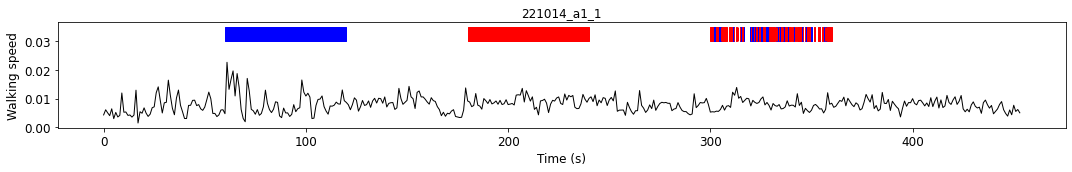

In [5]:
# plot behav
fig, ax = plt.subplots(1, 1, figsize=(15, 2.5*ntr), tight_layout=True, sharex=True)

for ctr, (spd, ax) in enumerate(zip(spds, [ax])):

    # plot stim and behav
    ax.plot(tbase, spd, c='k', lw=1)
    plot_b(
        ax, t_sng_loaded, sng_loaded, c=[(1, 1, 1), 'b', 'r'],
        extent=[60, 60+DT_SNG*len(sng_loaded), 0.03, .035])
    set_plot(ax, x_label='Time (s)', y_label='Walking speed', title=f'{FLIES[FLY_IDX]}_{ctr+1}', font_size=12)

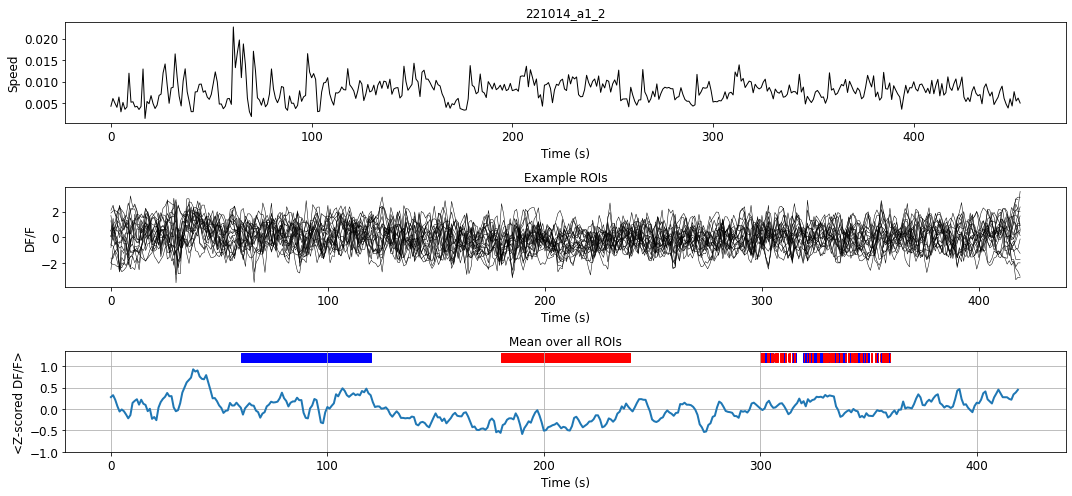

In [6]:
# load all neural data
dffs_all = []

expt = EXPTS[FLY_IDX][0]

data_dir = f'data/original/lin_imaging/nat_song_imaging/{expt}/supervoxels/'

dffs = []
slice_rois = []
for cslice in range(0, 9):
    fname = f'{expt}_n20_t420_slice{cslice}.h5'
    z_dff = loadmat_h5(os.path.join(data_dir, fname))['z_dff']

    for croi, dff in enumerate(z_dff.T):

        dff[get_outliers(dff, 3)] = np.nan
        dff = align_t([T_NRL], [dff], dt=DT_BHV, tbase=tbase)[1][0]
        dff = mv_avg(tbase, dff, 3)

        # z-score
        dff -= np.nanmean(dff)
        dff /= np.nanstd(dff)

        dffs.append(dff)
        
        slice_rois.append((cslice, croi+1))

dffs = np.array(dffs)
dffs_all.append(dffs)

fig, axs = plt.subplots(3, 1, figsize=(15, 7), tight_layout=True)
axs[0].plot(tbase, spds[ctr], c='k', lw=1)
set_plot(axs[0], x_label='Time (s)', y_label='Speed', title=f'{FLIES[FLY_IDX]}_2', font_size=12)

axs[1].plot(tbase, (dffs).T[:, :20], c='k', lw=.5)
set_plot(axs[1], x_label='Time (s)', y_label='DF/F', title='Example ROIs', font_size=12)

axs[2].plot(tbase, np.nanmean(dffs, axis=0), lw=2)
plot_b(axs[2], t_sng_loaded, sng_loaded, c=[(1, 1, 1), 'b', 'r'], extent=[60, 60+DT_SNG*len(sng_loaded), 1.1, 1.3])
axs[2].grid()
set_plot(axs[2], y_lim=(-1, 1.35), x_label='Time (s)', y_label='<Z-scored DF/F>', title='Mean over all ROIs', font_size=12)

# Plot individual ROIs

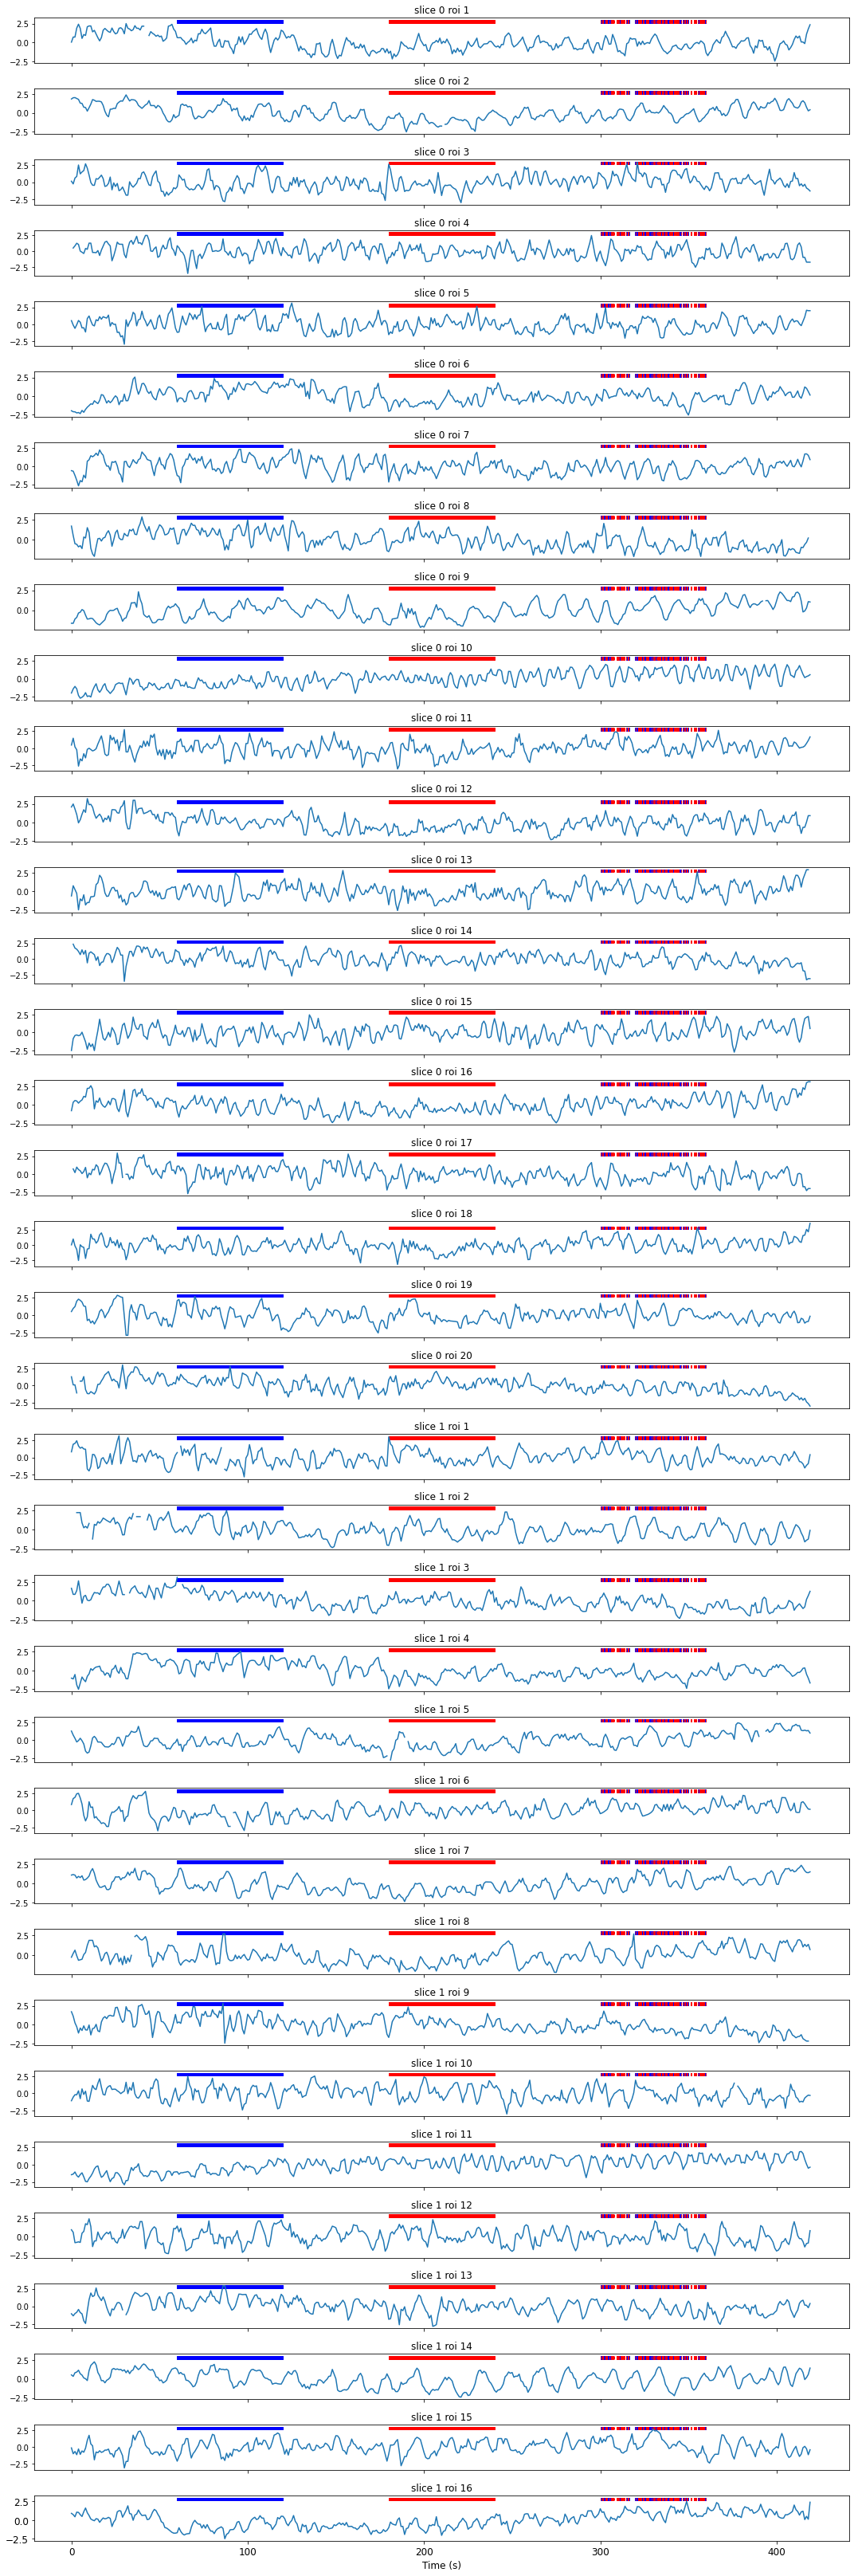

In [7]:
fig, axs = plt.subplots(36, 1, figsize=(15, 45), tight_layout=True, sharex=True)
n_per_ax = 1
for cax, ax in enumerate(axs):
    istart = cax*n_per_ax
    istop = (cax+1)*n_per_ax
    ax.plot(tbase, dffs.T[:, istart:istop])
    title = ', '.join([f'slice {cslice} roi {roi}' for cslice, roi in slice_rois[istart:istop]])
    plot_b(ax, t_sng_loaded, sng_loaded, c=[(1, 1, 1), 'b', 'r'], extent=[60, 60+DT_SNG*len(sng_loaded), 2.6, 3])
    set_plot(ax, title=title)
    
    
set_plot(axs[-1], x_label='Time (s)', font_size=12)

# Plot all ROIs

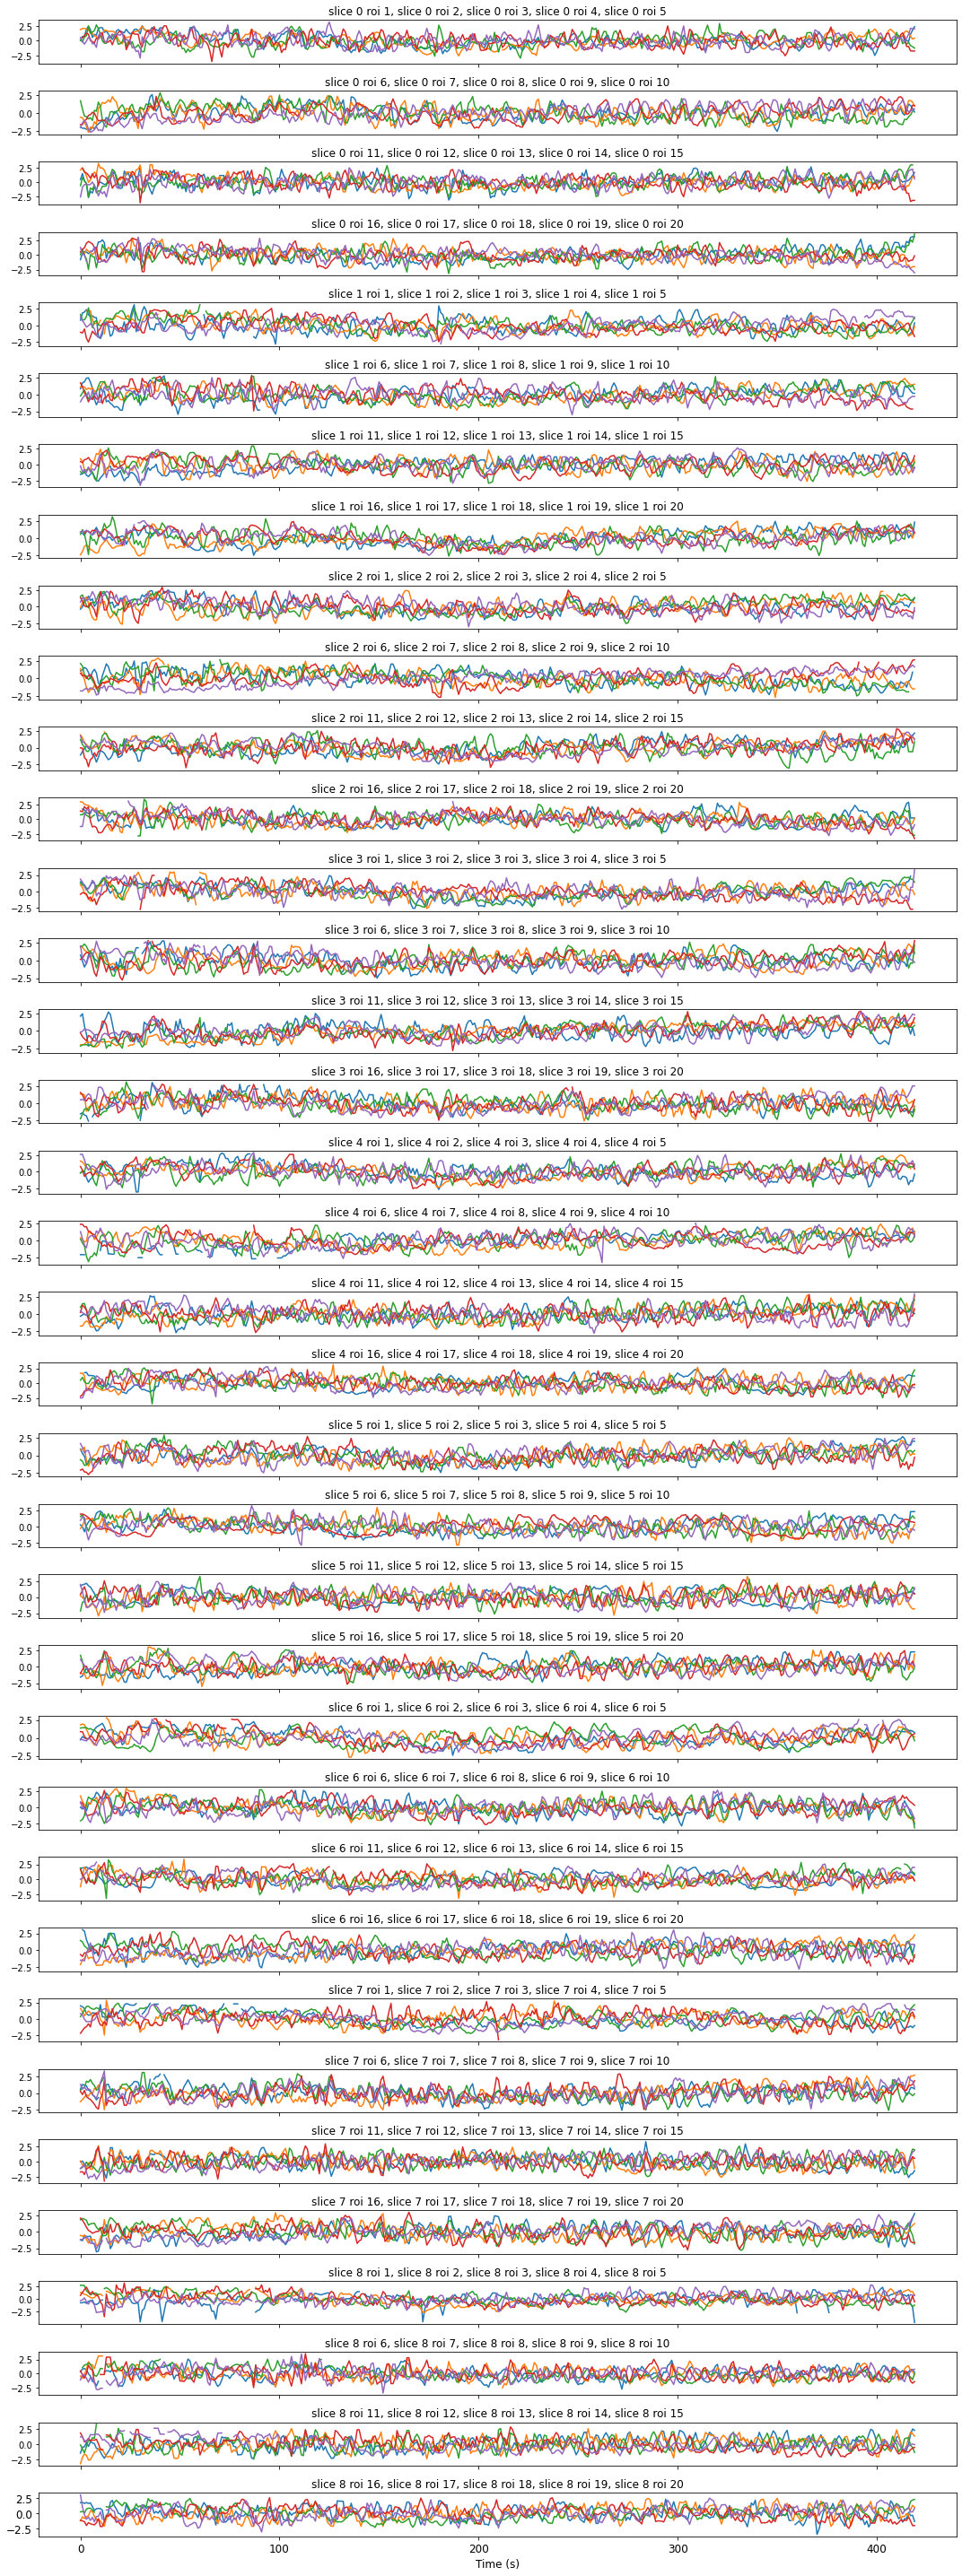

In [8]:
fig, axs = plt.subplots(36, 1, figsize=(15, 40), tight_layout=True, sharex=True)
n_per_ax = 5
for cax, ax in enumerate(axs):
    istart = cax*n_per_ax
    istop = (cax+1)*n_per_ax
    ax.plot(tbase, dffs.T[:, istart:istop])
    title = ', '.join([f'slice {cslice} roi {roi}' for cslice, roi in slice_rois[istart:istop]])
    set_plot(ax, title=title)
    
set_plot(axs[-1], x_label='Time (s)', font_size=12)

# Autocovariances of signal

Blue = original, black = detrended

....................................................................................................................................................................................

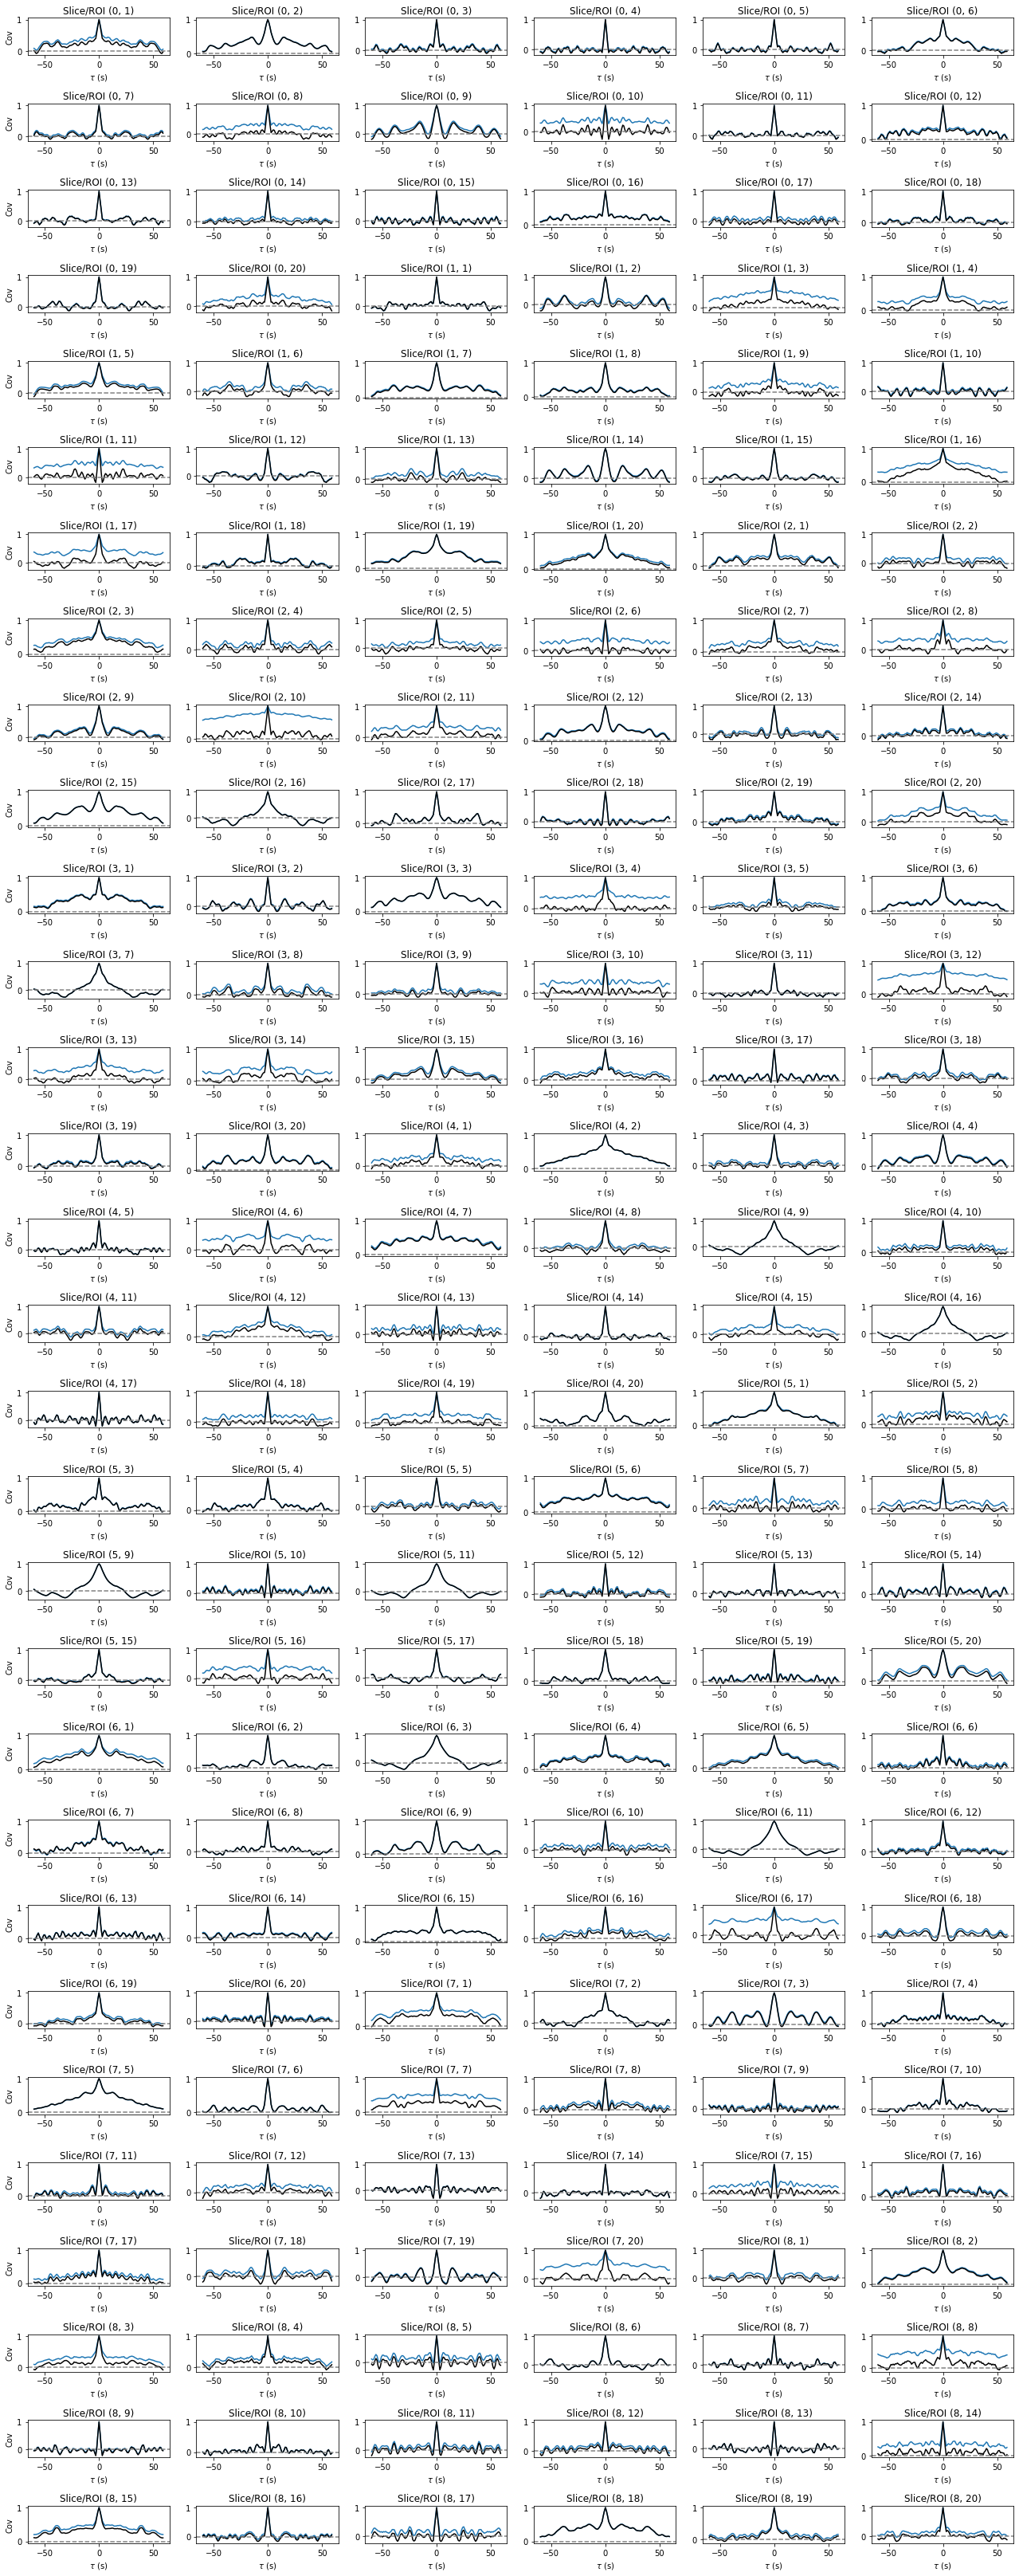

In [9]:
from time_stats import xcov_with_confidence, nan_detrend
import sys

lag = 60
tcov = np.arange(-lag, lag)

fig, axs = plt.subplots(30, 6, figsize=(18, 45), tight_layout=True)
for cax, (ax, dff) in enumerate(zip(axs.flatten(), dffs)):
    sys.stdout.write('.')
    cov = xcov_with_confidence(dff, dff, lag_forward=lag, lag_backward=lag, pre_norm=True)[0]
    ax.plot(tcov, cov)
    
    cov_det = xcov_with_confidence(nan_detrend(dff), nan_detrend(dff), lag_forward=lag, lag_backward=lag, pre_norm=True)[0]
    ax.plot(tcov, cov_det, c='k')
    
    ax.axhline(0, ls='--', color='gray')
    set_plot(ax, x_label=r'$\tau$ (s)', title=f'Slice/ROI {slice_rois[cax]}')
    
for ax in axs[:, 0]:
    set_plot(ax, y_label='Cov')

# Covariance matrix (not time-lagged)

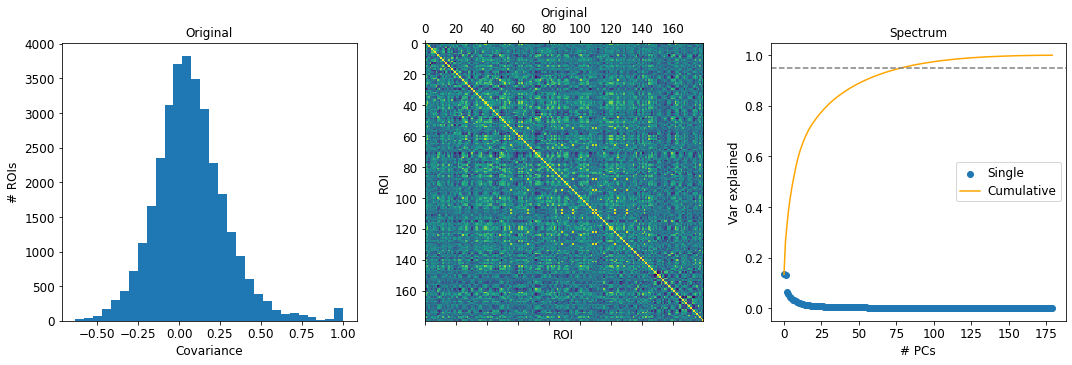

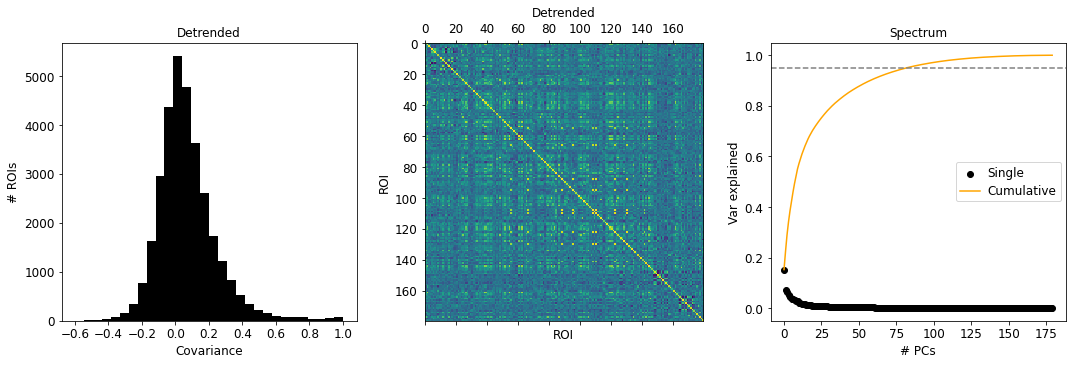

In [10]:
from time_stats import nan_cov

nroi = dffs.shape[0]
cov_mat = np.nan*np.eye(nroi)
cov_mat_dtr = np.nan*np.eye(nroi)

for croi_0 in range(nroi):
    dff_0 = dffs[croi_0]
    
    for croi_1 in range(nroi):
        dff_1 = dffs[croi_1]
        
        cov_mat[croi_0, croi_1] = nan_cov(dff_0, dff_1)
        cov_mat_dtr[croi_0, croi_1] = nan_cov(nan_detrend(dff_0), nan_detrend(dff_1))
        
fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
axs[0].hist(cov_mat.flatten(), bins=30)
set_plot(axs[0], x_label='Covariance', y_label='# ROIs', title='Original', font_size=12)

axs[1].matshow(cov_mat)
set_plot(axs[1], x_label='ROI', y_label='ROI', title='Original', font_size=12)

evs = np.sort(np.linalg.eig(cov_mat)[0].flatten())[::-1]
var = np.sum(evs)
axs[2].scatter(np.arange(nroi), evs/var)
axs[2].plot(np.arange(nroi), evs.cumsum()/var, c='orange')
axs[2].axhline(.95, color='gray', ls='--')
axs[2].legend(['Single', 'Cumulative'])
set_plot(axs[2], x_label='# PCs', y_label='Var explained', title='Spectrum', font_size=12)

fig, axs = plt.subplots(1, 3, figsize=(15, 5), tight_layout=True)
axs[0].hist(cov_mat_dtr.flatten(), bins=30, color='k')
set_plot(axs[0], x_label='Covariance', y_label='# ROIs', title='Detrended', font_size=12)

axs[1].matshow(cov_mat_dtr)
set_plot(axs[1], x_label='ROI', y_label='ROI', title='Detrended', font_size=12)

evs = np.sort(np.linalg.eig(cov_mat_dtr)[0].flatten())[::-1]
var = np.sum(evs)
axs[2].scatter(np.arange(nroi), evs/var, c='k')
axs[2].plot(np.arange(nroi), evs.cumsum()/var, c='orange')
axs[2].axhline(.95, color='gray', ls='--')
axs[2].legend(['Single', 'Cumulative'])
set_plot(axs[2], x_label='# PCs', y_label='Var explained', title='Spectrum', font_size=12)